In [2]:
## 다중 클래스 구조
# = 확률적 경사 하강법(Stochastic Gradient Descent) 또는 미니 배치 학습법(mini-batch learning)

#MNIST
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tqdm.notebook import tqdm
plt.style.use('seaborn-whitegrid')

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
#dataset 형태
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


(28, 28)
5


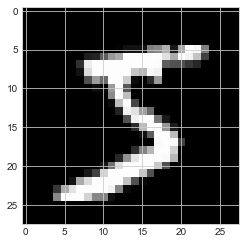

In [5]:
img = x_train[0]
print(img.shape)

plt.imshow(img, cmap='gray')
print(y_train[0])

In [6]:
#데이터 전처리 (이미지 2차 배열을 1차 배열로 flatten)
def flatten_for_mnist(x):
    temp = np.zeros((x.shape[0], x[0].size))
    
    for idx, data in enumerate(x):
        temp[idx, :] = data.flatten()
        
    return temp

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = flatten_for_mnist(x_train)
x_test = flatten_for_mnist(x_test)

print(x_train.shape)
print(x_test.shape)

y_train_ohe = tf.one_hot(y_train, depth=10).numpy()
y_test_ohe = tf.one_hot(y_test, depth=10).numpy()

print(y_train_ohe.shape)
print(y_test_ohe.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [8]:
print(x_train[0].max(), x_train[0].min())
print(y_train_ohe[0])

1.0 0.0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [23]:
#하이퍼 파라미터 Hyper Parameter
epochs = 5
lr = 0.3
batch_size = 100
train_size = x_train.shape[0]

In [24]:
#유틸 함수 Util Functions
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def mean_squared_error(pred_y, true_y):
    return np.mean(np.sum(np.square((true_y - pred_y))))

def cross_entropy_error(pred_y, true_y):
    if true_y.ndim == 1:
        true_y = true_y.reshape(1, -1)
        pred_y = pred_y.reshape(1, -1)
        
    delta = 1e-7
    return -np.sum(true_y * np.log(pred_y + delta))

def cross_entropy_error_for_batch(pred_y, true_y):
    if true_y.ndim == 1:
        true_y = true_y.reshape(1, -1)
        pred_y = pred_y.reshape(1, -1)
        
    delta = 1e-7
    batch_size = pred_y.shape[0]
    return -np.sum(true_y * np.log(pred_y + delta)) / batch_size

def cross_entropy_error_for_bin(pred_y, true_y):
    return 0.5 * np.sum((-true_y * np.log(pred_y) - (1 - true_y) * np.log(1 - pred_y)))

def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

def differential_1d(f, x):
    eps = 1e-5
    diff_value = np.zeros_like(x)
    

    for i in range(x.shape[0]):
        temp_val = x[i]
        
        x[i] = temp_val + eps
        f_h1 = f(x)
        
        x[i] = temp_val - eps
        f_h2 = f(x)
        
        diff_value[i] = (f_h1 - f_h2) / (2 * eps)
        x[i] = temp_val
        
    return diff_value

def differential_2d(f, X):
    if X.ndim == 1:
         return differential_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = differential_1d(f, x)
        
        return grad

In [25]:
#2층 신경망
class MyModel(object):
    
    def __init__(self):
        
        def weight_init(input_nodes, hidden_nodes, output_units):
            np.random.seed(777)
            params = {}
            params['w_1'] = 0.01 * np.random.randn(input_nodes, hidden_nodes)
            params['b_1'] = np.zeros(hidden_nodes)
            params['w_2'] = 0.01 * np.random.randn(hidden_nodes, output_units)
            params['b_2'] = np.zeros(output_units)
            return params
        
        self.params = weight_init(784, 64, 10)
        
    def predict(self, x):
        W_1, W_2 = self.params['w_1'], self.params['w_2']
        B_1, B_2 = self.params['b_1'], self.params['b_2']
        
        A1 = np.dot(x, W_1) + B_1
        Z1 = sigmoid(A1)
        A2 = np.dot(Z1, W_2) + B_2
        pred_y = softmax(A2)
        
        return pred_y
    
    def loss(self, x, true_y):
        pred_y = self.predict(x)
        return cross_entropy_error_for_bin(pred_y, true_y)
    
    def accuracy(self, x, true_y):
        pred_y = self.predict(x)
        y_argmax = np.argmax(pred_y, axis=1)
        t_argmax = np.argmax(true_y, axis=1)
        accuracy = np.sum(y_argmax == t_argmax) / float(x.shape[0])
        return accuracy
    
    def get_gradient(self, x, t):
        def loss_grad(grad):
            return self.loss(x, t)
        
        grads = {}
        grads['w_1'] = differential_2d(loss_grad, self.params['w_1'])
        grads['b_1'] = differential_2d(loss_grad, self.params['b_1'])
        grads['w_2'] = differential_2d(loss_grad, self.params['w_2'])
        grads['b_2'] = differential_2d(loss_grad, self.params['b_2'])
        
        return grads

In [26]:
#모델 생성 및 학습
model = MyModel()

train_loss_list = list()
train_acc_list = list()
test_acc_list = list()
iter_per_epoch = max(train_size / batch_size, 1)

start_time = time.time()
for i in tqdm(range(epochs)):
    
    batch_idx = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_idx]
    y_batch = y_train_ohe[batch_idx]
    
    grads = model.get_gradient(x_batch, y_batch)
    
    for key in grads.keys():
        model.params[key] -= lr * grads[key]
        
    loss = model.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    train_accuracy = model.accuracy(x_train, y_train_ohe)
    test_accuracy = model.accuracy(x_test, y_test_ohe)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    
    print("Epoch: {}, Cost: {}, Train Accuracy: {}, Test Accuracy: {}"
         .format(i+1, loss, train_accuracy, test_accuracy))
    
end_time = time.time()
print("총 학습 소요시간: {:.3f}s".format(end_time - start_time))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1, Cost: 913.4871128983332, Train Accuracy: 0.10441666666666667, Test Accuracy: 0.1028
Epoch: 2, Cost: 410.57309964955533, Train Accuracy: 0.09751666666666667, Test Accuracy: 0.0974
Epoch: 3, Cost: 452.0649921784976, Train Accuracy: 0.09871666666666666, Test Accuracy: 0.098
Epoch: 4, Cost: 376.3738433788608, Train Accuracy: 0.10218333333333333, Test Accuracy: 0.101
Epoch: 5, Cost: 381.6949051777194, Train Accuracy: 0.0993, Test Accuracy: 0.1032
총 학습 소요시간: 119.923s


In [31]:
model.predict(x_train[0])

array([6.25927895e-02, 1.05181100e-01, 1.89510909e-01, 4.47110538e-02,
       1.03539915e-01, 1.04549135e-01, 1.31130957e-01, 1.10196788e-04,
       1.40088465e-01, 1.18585478e-01])